In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

# Autoregressive Models

## AR: Time Series

In [ ]:
def simulate_ar(n: int, w: np.ndarray) -> np.ndarray:
    """Simulate AR(p) process.

    :param n : number of samples
    :param w : weight vector
    :returns x: signal
    """

    # order (how many past values)
    p = len(w)

    # pad for initilization
    x = np.random.randn(n + p)

    # randomness
    error = np.random.randn(len(x))

    # create signal
    for i in range(p, len(x)):
        # use past values to generate future values
        x[i] = (x[i-p:i] @ w) + error[i-p]

    # remove initial padding
    x = x[p:]

    # normalize
    x = (x - x.mean()) / x.std()

    return x

## AR(1)

AR(1) refers to using a single past value to predict future values.

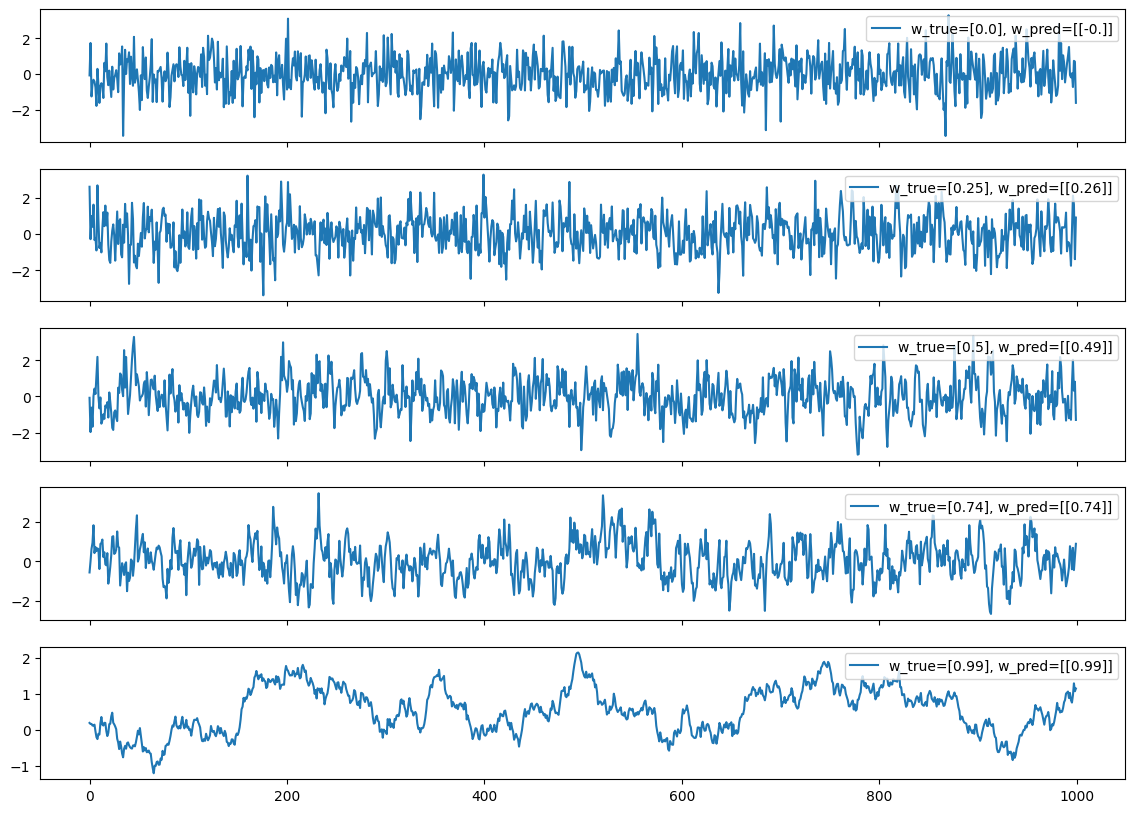

In [ ]:
# Simulate a few examples and plot
weights = np.linspace(0, 0.99, 5).reshape(-1, 1)

fig, axes = plt.subplots(nrows=len(weights), ncols=1, figsize=(14, 10), sharex=True)

for i in range(len(weights)):

    # Simulate
    x = simulate_ar(10_000, weights[i])

    # Fit AR(1) coefficient
    past_values = x[:-1]
    future_values = x[1:]
    w_pred, residuals, rank, singular_values = np.linalg.lstsq(past_values.reshape(-1, 1), future_values)

    axes[i].plot(x[:1000], label=f"w_true=[{weights[i, 0].round(2)}], w_pred=[{w_pred.round(2)}]")
    axes[i].legend(loc="upper right")

### AR(3)

AR(3) uses the past three values to predict future values. As the complexity of the model increases, the model can flexibly model various forms.

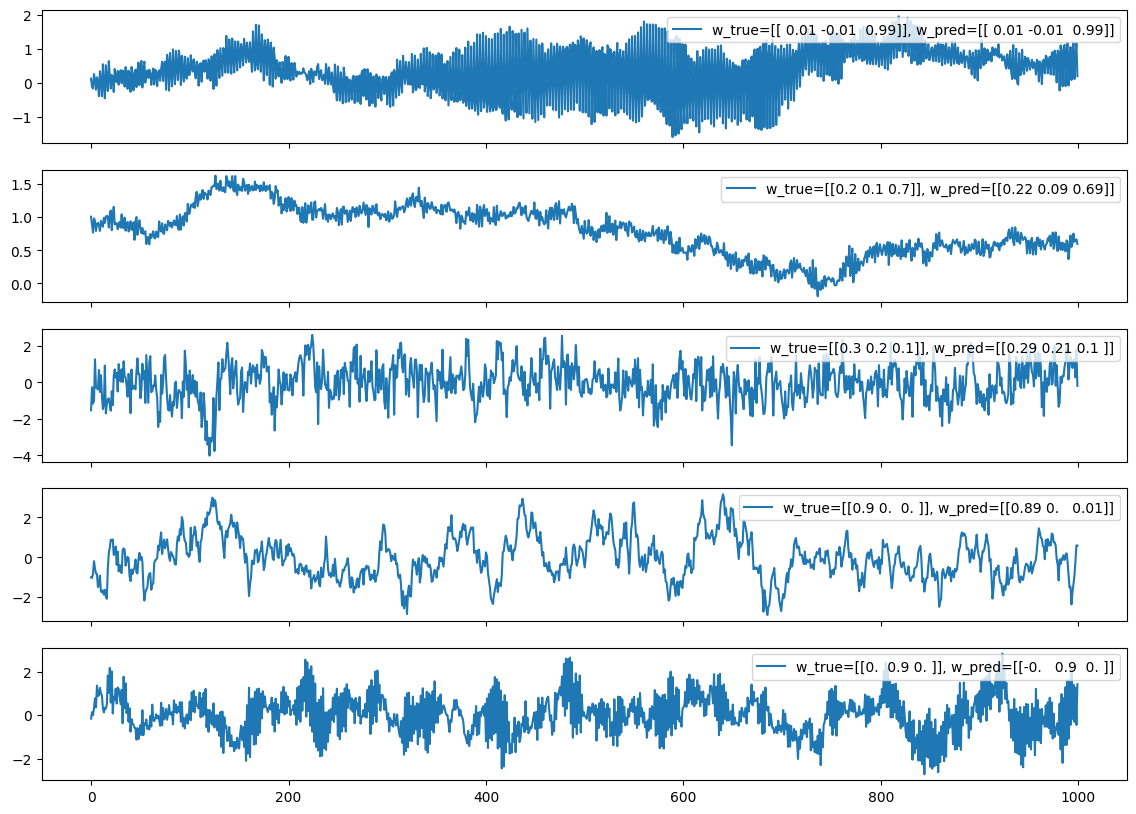

In [ ]:
# Simulate a few examples and plot
np.random.seed(0)
weights = np.array([
    [0.99, -.01, .01],
    [0.7, .1, .2],
    [.1, .2, .3],
    [0, 0, .9],
    [0, 0.9, 0]
])

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

for i in range(len(weights)):

    # Simulate
    x = simulate_ar(10_000, weights[i])

    # Use statsmodels to fit AR(1) coefficient
    past_values = np.lib.stride_tricks.sliding_window_view(x, 3, axis=0)[:-1]
    future_values = x[3:]
    w_pred, residuals, rank, singular_values = np.linalg.lstsq(past_values.reshape(-1, 3), future_values)

    axes[i].plot(x[:1000], label=f"w_true=[{weights[i][::-1].round(2)}], w_pred=[{w_pred[::-1].round(2)}]")
    axes[i].legend(loc="upper right")

### AR(3): Solve with Pytorch

In [ ]:
# Define model
class Model(torch.nn.Module):
    def __init__(self, n_past_values):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(n_past_values))
        self.b = torch.nn.Parameter(torch.randn(1))
    def forward(self, past_values):
        return past_values.matmul(self.w) + self.b

# Simulate
w_true = np.array([0.7, .1, .2])
x = simulate_ar(10_000, w_true)
x = (x - x.mean()) / x.std()

# Past and future values
past_values = torch.from_numpy(
    np.lib.stride_tricks.sliding_window_view(x, 3, axis=0)[:-1].copy()
).float()
future_values = torch.from_numpy(x[3:]).float()

# Setup model
model = Model(3)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.)

# Training
for i in range(2000):
    predicted_future_values = model(past_values)
    loss = loss_fn(future_values, predicted_future_values)
    loss.backward()       # compute gradient
    optimizer.step()      # step parameters in direction of gradient
    optimizer.zero_grad() # reset gradient

print("predicted weights: ", model.w.detach().numpy())
print("true weights: ", w_true)

predicted weights:  [0.69236416 0.09735332 0.20992859]
true weights:  [0.7 0.1 0.2]


## AR: Images

## AR(2): 2d

### Directional

In [ ]:
from convolutional_ar.model import ConvAR
import torch.nn.functional as F

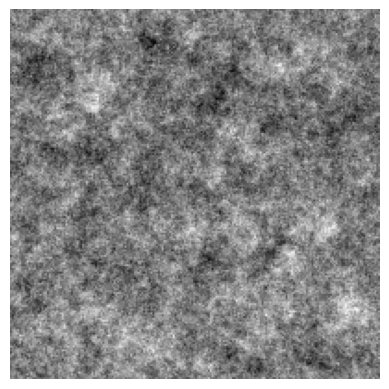

In [ ]:
# Settings
n, sweeps = 200, 200
w = np.array([0.9, 0.1], dtype=np.float32)
w0, w1 = map(float, w)

# Symmetric kernel
kernel = torch.tensor([
    [w1, w0, w1],
    [w0, 0., w0],
    [w1, w0, w1],
], dtype=torch.float32)

k = kernel[None, None]  # unsqueeze to (1, 1, 3,3)

# Simulate
img = torch.zeros(n + 2, n + 2, dtype=torch.float32)
for _ in range(sweeps):
    for a in (0, 1):
        for b in (0, 1):
            eps = torch.randn_like(img)
            
            # weighted neighbor sum
            mu = F.conv2d(img[None, None], k)[0, 0]

            # update only this sublattice of interior pixels
            img[1+a:n+1:2, 1+b:n+1:2] = mu[a::2, b::2] / 4.0 + eps[1+a:n+1:2, 1+b:n+1:2]

patches = F.unfold(img[None, None], kernel_size=3).squeeze(0).T
axis_idx, diag_idx, center_idx = [1,3,5,7], [0,2,6,8], 4

# Xw = y
X = torch.stack([patches[:, axis_idx].mean(1),
                 patches[:, diag_idx].mean(1)], dim=1)
y = patches[:, center_idx]

# Plot
img_show = img[1:n+1, 1:n+1]
img_show = (img_show - img_show.mean()) / img_show.std().clamp_min(1e-8)
plt.imshow(img_show.numpy(), cmap="gray"); plt.axis("off"); plt.show()


In [ ]:
# Solve with least squares
w_pred, *_ = np.linalg.lstsq(X.numpy(), y.numpy(), rcond=None)
print("w_pred:", w_pred)
print("w_true:", w)

w_pred: [0.90996426 0.09160044]
w_true: [0.9 0.1]


In [ ]:
# Solve with pytorch, our package
model = ConvAR(radius=1, lr=1e-1, n_epochs=100)
model.fit(img)
print()
print("w_pred:", model.weight_vector_ * 4)
print("w_true:", w)

model 0, epoch 99, loss 1.0023466348648071

w_pred: tensor([[0.9095, 0.0913]])
w_true: [0.9 0.1]
